# Mobility characterization

In this Notebook, we study in more the detail the mobility of the pedestrians by obtaining some key features used to characterize the mobility. 

**1. Averaged Individual Mean Squared Displacement (MSD)**. The mean squared displacement measures the quadratic distance (i.e., the deviation) of the position of a particle/individual with respect to a reference position over time. For a single individual, we obtain the averaged MSD, in which we average over all possible reference positions).

    1.1- Plot MSD(s) for each trajectory and averaging over all trajectories.
    1.2- Power-law fit <MSD(s)>.


**2. Individual auto-correlation velocities C(s)**. We measure the auto-correlation of the instantaneous velociti v(t), for each trajectory. It measures the memory/similarity between observations of a variable as a function of the "time lag" between them. 

    2.1- Plot C(s) for each trajectory and averaging over all trajectories.
    2.2- Double-exponential fit <C(s)>.
    

**3. Probability density function velocities. Log-Normal distribution fit**. We obtain the PDF of all instantaneous velocities and fit it with a Log-Normal distribution.


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 1. Averaged Individual Mean Squared Displacement (MSD)

We obtain the averaged mean squared displacement for a single trajectory, which gives a measure of the type of difussion, using the distance of each pair of locations separated by "s" timesteps/positions.

$$  MSD(s) = \frac{1}{N-s} \sum_{i=0}^{N-s-1} \vert \vec{r}(i+s)-\vec{r}(i) \vert^{2} $$

where $N$ is the total number of GPS points in the trajectory and $s$ the separation between locations/timesteps. The proceed to obtain $ MSD(s)$ is the following:

    1. For a timestep (or position separation) of s = 1, we obtain all the distances between pairs of locations separated by s=1 timesteps. That is:  
    
$$ \vert \vec{r}(1)-\vec{r}(0) \vert^{2}, \vert \vec{r}(2)-\vec{r}(1) \vert^{2}, ... , \vert \vec{r}(N)-\vec{r}(N-1) \vert^{2}$$

    2. Then we average to obtain the averaged MSD at s=1:
    
$$  MSD(1) = \frac{1}{N-1} \sum_{i=0}^{N-2} \vert \vec{r}(i+1)-\vec{r}(i) \vert^{2}$$
  

    3. Then, we move to s=2 and repeat the steps above (1,2) for locations separated by 2 timesteps/positions:
    
$$ \vert \vec{r}(2)-\vec{r}(0) \vert^{2}, \vert \vec{r}(3)-\vec{r}(1) \vert^{2}, ... , \vert \vec{r}(N)-\vec{r}(N-2) \vert^{2}$$
    
$$ \ MSD(2)  = \frac{1}{N-2} \sum_{i=0}^{N-3} \vert \vec{r}(i+2)-\vec{r}(i) \vert^{2}$$

    4. And so on up to S=N/4, in order to have enough data for the averages. N/4 is suggested by [Saxton, M. J. (1997). Single-particle tracking: the distribution of diffusion coefficients. Biophysical journal, 72(4), 1744-1753].



We can compare the data with a power-law of the form $MSD(T)\sim T^{\gamma}$, and we can distinct four cases:

$\gamma < 1$: subdiffusive regime

$\gamma =1$: brownian motion

$\gamma>1$: superdiffusive regime

$\gamma =2$: ballistic movement (constant velocity, no dispersion, fully oriented)


In our case we obtain $MSD(s)$, using $s$ rather than the time $t$ since we are using points that are not uniformly separated in time (In average, the Wikilop app. collects data every 5-6 seconds. However, there are very long time increments due to the fact that the app. stops collecting data where it detects that there is no movement). 

In [143]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.random import shuffle
from math import sin, cos, sqrt, atan2, radians


def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    """ Function that returns the distance in metres between 2 GPS locations in degrees (latitude and longitude).
    It is based in the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula) which takes into account the
    Earth's curvature. 
    
    Input:
        - 2 GPS coordinates: (latitude1,longitude1) of the first point and (latitude2,longitude2) of the second point. 
        
    Output:
        - Distance in metres between the two GPS locations.
    """
    
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)  # Diference between latitudes in radians
    dLon = radians(lon2-lon1) # Diference between longitudes in radians
    rLat1 = radians(lat1)   # Latitudes in radians
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 # Distance in m
   
    return e


def avg_individual_mean_squared_displacement(df):
    """ This function returns the averaged mean squared displacement (MSD) for an individual trajectory comoposed of N locations
        
        1. We first obtain the squared distances between locations separated by s=1 timestep. That is:
             MSD(s=1) = |r(1)-r(0)|^2, |r(2)-r(1)|^2, |r(3)-r(2)|^2, |r(4)-r(3)|^2,..., |r(N)-r(N-1)|^2
            
        2. Then we average all the distances for the given "s". 
            <MSD(s=1)> = 1/(N-1) * SUM |r(t+1)-r(t)|^2,  where the summation goes from t=0 to t=N-1
            
        3. Then we repeat the steps above (1,2) with s=2 ---> <MSD(s=2)>. and so on up to s=N/4, being N the total number of
           locations in the trajectory.
           
        So the general equation for a given "s" is:
            <MSD(s)> = 1/(N-s) * SUM |r(t+s)-r(t)|^2, where the summation goes from t=0 to t=N-1.
            
        Inputs:
            - The input is the data-frame with the columns the positions of the trajectory (latitude, longitude) and 
              the timestamp-
              
        Outputs:
            - List of the averaged MSD for each "timestep" s, <MSD(s)>, of length N/4.
            - List of the cumulative time up to s=N/4.
            - List of s=N/4 points in the trajectory (1,2,3,4...,N/4).
    """

    # latitude, longitude and time difference to lists
    latitude = df['lat'].tolist()
    longitude = df['lon'].tolist()
    At = df['At'].tolist()
    
    N4=int(len(df)/4)
    At_cumsum = np.cumsum(At[:N4-1])
    
    print('The location N/4 = {} corresponds to the second {} of the trajectory'.format(N4, At_cumsum[-1]))
          
    # MSD = < |r(t+s)-r(t)|^2 >
    # Computes the distances between the position "t" and the position at "t+s" and append in a list the squared distances (MSD).
    # Then, for a given s, we average all the squared distances. 
    # Exemple, if s=1, we obtain the quadratic distances between each pair of points separated by 1 (i.e., r(1)-r(0), r(2)-r(1),
    # r(3)-r(2)...) and so on. And then we compute  < r(t+1)-r(t) >. Then we move to s=2 and repeat, until s=N/4 (being N the
    # number of GPS locations in the trajectory)
    
    mean_squared_distance_s = []
    n_points = []
    # Loop over all "time-steps" or "position-steps" (i.e., locations separated by "s" steps). Up to N = s/4 (being N the number
    # of GPS locations in the trajectory)
    for s in range(1,N4):  
        n_points.append(s)
        squared_distance=[]
        # This loop computes all the squared distances between locations separated by "s" timesteps (recalling that the 
        # timesteps are irregular). We store in a list the average value for a given "s".
        for x, y, z, t in zip(latitude[0::], longitude[0::], latitude[s::], longitude[s::]):   
            dist = getDistanceFromLatLonInM(x,y,z,t)
            squared_distance.append(abs(dist)**2) 
        
        mean_squared_distance_s.append(np.mean(squared_distance))
        
    return At_cumsum, mean_squared_distance_s,n_points








## 1.1. Plot MSD(s) for each trajectory and averaging over all trajectories

· We plot the MSD(s) for each trajectory, being $s$ the separation between locations (s=1 mean that the squared distance is obtained between pairs of locations separated by 1 postion/timestep). 

· We also perform, at each $s$, averages over all trajectories and plot



e1.csv
The location N/4 = 40 corresponds to the second 721.0 of movement

e2.csv
The location N/4 = 33 corresponds to the second 743.0 of movement

e3.csv
The location N/4 = 51 corresponds to the second 942.0 of movement

e4.csv
The location N/4 = 30 corresponds to the second 807.0 of movement

e5.csv
The location N/4 = 45 corresponds to the second 702.0 of movement

e6.csv
The location N/4 = 64 corresponds to the second 1483.0 of movement

e7.csv
The location N/4 = 57 corresponds to the second 1153.0 of movement

g1.csv
The location N/4 = 56 corresponds to the second 1615.0 of movement

g2.csv
The location N/4 = 13 corresponds to the second 76.0 of movement

g3.csv
The location N/4 = 37 corresponds to the second 2128.0 of movement

g4.csv
The location N/4 = 16 corresponds to the second 90.0 of movement

g5.csv
The location N/4 = 35 corresponds to the second 972.0 of movement

g6.csv
The location N/4 = 21 corresponds to the second 150.0 of movement

g7.csv
The location N/4 = 39 corresp

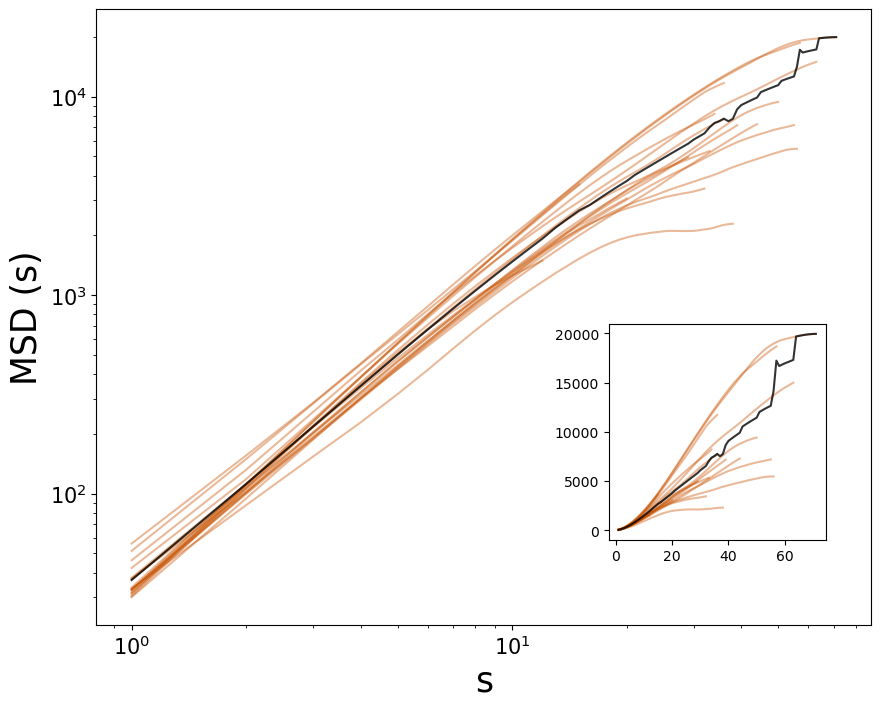

In [144]:
all_files = glob.glob(os.path.join("processed data\\*.csv")) # Make list of paths (csv files for all individual trajectories)

# Create the figure
fig, ax1 = plt.subplots(figsize=(10,8))   
axins1 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,0.15,.35,.35), bbox_transform=ax1.transAxes)
ax1.set_ylabel('MSD (s)',fontsize=25)
ax1.set_xlabel('s',fontsize=25)
ax1.tick_params(labelsize=15)
ax1.set_yscale('log',base=10) 
ax1.set_xscale('log',base=10) 

msd_all=[] # List of lists:  msd_all = [ [MSD(s)_traject_1], [MSD(s)_traject_2], ...,[] ]
number_of_trajectories=0
label_added = False  # To avoid plot multiple legend values
for file in all_files:   # Loop over all .csv files
    df = pd.read_csv(file)
    number_of_trajectories = number_of_trajectories + 1
    
    print(file)
    At_cumsum, msd,n_points = avg_mean_squared_error(df)
    print('')
    
    msd_all.append(msd)  # List of lists. Each list is the individual average MSD(s) (unique trajectory)
    
    if not label_added:
        ax1.plot(n_points, msd, '-', color='#C85200',alpha=0.4,label='MSD(s)')  # Plot each trajectory (MSD) individually
        axins1.plot(n_points, msd,'-',color='#C85200',alpha=0.4)
        label_added = True
    else:
        ax1.plot(n_points, msd, '-', color='#C85200',alpha=0.4)  # Plot each trajectory (MSD) individually
        axins1.plot(n_points, msd,'-',color='#C85200',alpha=0.4)

    
    
# AVERAGE OVER ALL TRAJECTORIES (AT EACH "S")
length_largest_msd_list = len(max(msd_all))  # lenght of the largest MSD list (of all the trajectories)

msd_all_traj_avg=[]
ss=0
n_points_largest_traject=[]
for s in range(length_largest_msd_list):   # Loop from s=0 to the lenght of the largest trajectory (MSD list)
    msd_all_s=[]
    for i in msd_all:   # Loop over every MSD list 
        if len(i)>s:  # Necessary condition since each MSD list has different length. We can only store a value of the MSD of a
                      # given list if its length is larger than "s". Of course, the last iteration p = length_largest_msd_list 
                      # will only store 1 value corresponding to the MSD(s) value of the largest list (largest trajectory).
                    
            msd_all_s.append(i[s])
    msd_all_traj_avg.append(np.mean(msd_all_s))  # We store the average over all trajectories for a given "s".
    ss=ss+1
    n_points_largest_traject.append(ss)

# Plot averaged MSD over all trajectories (at each s)
ax1.plot(n_points_largest_traject, msd_all_traj_avg, '-', color='black',label=r'$\langle MSD(s) \rangle_{traject}$',alpha=0.8)    
axins1.plot(n_points_largest_traject, msd_all_traj_avg, '-', color='black',alpha=0.8)

plt.show()
    

## 1.2. Power-law fit < MSD(s) >

· We fit the averaged MSD(s) over all trajectories (at each s) with a power-law of the form $\langle MSD(s) \rangle \sim s^{\gamma}$. The exponent $\gamma$ indicates the type of movement (diffusion)

The FIT exponents are:
For  0 < s < 10:  γ = 1.56 ± 0.01
For  10 < s < 50:  γ = 1.25 ± 0.01


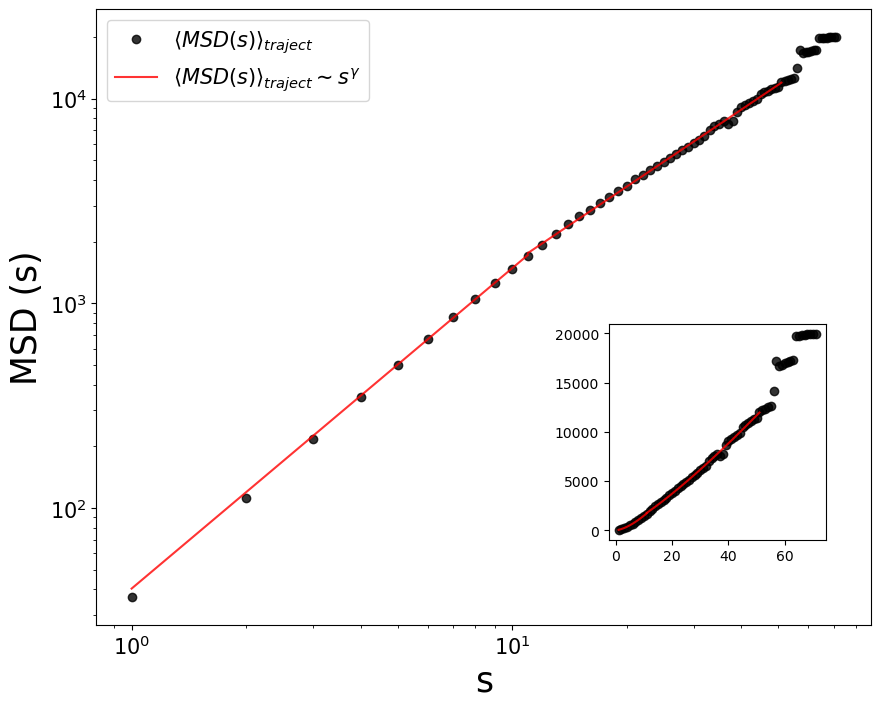

In [145]:
fig, ax1 = plt.subplots(figsize=(10,8))   
axins1 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,0.15,.35,.35), bbox_transform=ax1.transAxes)
ax1.set_ylabel('MSD (s)',fontsize=25)
ax1.set_xlabel('s',fontsize=25)
ax1.tick_params(labelsize=15)
ax1.set_yscale('log',base=10) 
ax1.set_xscale('log',base=10)

# Plot averaged MSD over all trajectories (at each s)
ax1.plot(n_points_largest_traject, msd_all_traj_avg, 'o', color='black',label=r'$\langle MSD(s) \rangle_{traject}$',alpha=0.8)    
axins1.plot(n_points_largest_traject, msd_all_traj_avg, 'o', color='black',alpha=0.8)
    
    
# POWER-LAW FIT 

# Power-law
def powerlaw(x,a,gamma):  #f(x)=a·x^alpha to fit MSD.
    return a*x**gamma
    
# CURVE-FIT. LEAST-SQUARES
popt, pcov = curve_fit(powerlaw, n_points_largest_traject[:10], msd_all_traj_avg[:10], p0=(1,1))
times = np.arange(n_points_largest_traject[0], n_points_largest_traject[10], 0.01)
model = powerlaw(times, *popt)
perr = np.sqrt(np.diag(pcov))  #calcul error del parametre

popt2, pcov2 = curve_fit(powerlaw, n_points_largest_traject[10:50], msd_all_traj_avg[10:50], p0=(1,1))
times2 = np.arange(n_points_largest_traject[10], n_points_largest_traject[50], 0.01)
model2 = powerlaw(times2, *popt2)
perr2 = np.sqrt(np.diag(pcov2))  #calcul error del parametre

ax1.plot(times, model, '-', color='red',label=r'$\langle MSD(s) \rangle_{traject} \sim s^{\gamma}$',alpha=0.8)
ax1.plot(times2, model2, '-', color='red',alpha=0.8)

axins1.plot(times, model, '-', color='red',alpha=0.8)
axins1.plot(times2, model2, '-', color='red',alpha=0.8)

ax1.legend(fontsize=15)

print('The FIT exponents are:')
print('For  0 < s < 10:  \u03B3 = {:.2f} \u00B1 {:.2f}'.format(popt[1],perr[1]))
print('For  10 < s < 50:  \u03B3 = {:.2f} \u00B1 {:.2f}'.format(popt2[1],perr2[1]))

plt.show()

# 2. Invidiual auto-correlation velocities C(s)

We obtain the velocities autocorrelation of an individual trajectory for consecutive velocities (labelled as "moving"), using a "step" window of $s$ positions. It is not a time-window since the time step between consecutive records is irregular.

$$ C(s)=\frac{ \left[ v(t)-\langle v(t)\rangle \right] \left[v(t+s)-\langle v(t)\rangle \right] }{ \left[ v(t)-\langle v(t)\rangle \right]^{2} } $$

The auto-correlation is rescaled (substracting the mean and dividing by the standard deviation). 

The proceed to obtain $C(s)$ is the following:

1. Obtain the instantenous velocity vector of a single trajectory (only those velocities labelled as moving in the data-set).


2. Re-scale the velocity vector by substracting the mean value to each instantaneous velocity and dividing over the standard deviation).


3. For a time/step window of $s=1$, compute and average the value of the auto-correlation $C(s=1)$:

$$ C(s=1) = \frac{1}{M-1} \sum_{j=0}^{M-2} \frac{ \left[ v(t)-\langle v(t)\rangle \right] \left[v(t+1)-\langle v(t)\rangle \right] }{ \left[ v(t)-\langle v(t)\rangle \right]^{2} } $$ 

where $M$ is the number of instantaneous velocities in the trajectory (Of course, $M=N-1$, being $N$ the number of GPS records in the trajectory). 


4. Then, we repeat the proceed above for $s=2$ and up to $s=M-1$. The case of s=M-1 it only contains one single value to average (which is the autocorrelation between the first velocity, $v_{0}$, and the last one, $v_{M-1}$). Of course, the larger the $s$, the less data we have and the autocorrelation loses statistical significance. 


5. Finally, we can also average the value of the auto-correlation over all the trajectories. and fit the experimental data with an exponential distribution of the form $C(\tau) \sim e^{-\frac{\tau}{\alpha}}$.


NOTE:

    1. The value of "s" can be misunderstood as a "time-window", but we have irregular time-steps between GPS records (and
    therefore velocities). On average, the Wikiloc app. collects data every 5s quite uniformly. However, if there are large
    stops during the trip, we can have consecutive GPS records with a time difference of hundreds or thousands of seconds. 
    For this reason, when averaging (for a single trajectory) all pairs v(t)·v(t+s) for a given "s", we have to take into
    account that these consecutive velocities are not necessarily separated by a constant time window of "s" seconds. 
    Instead, we should understand "s" as the step position in the velocity vector. The ideal case would be to have all the
    collected data separated uniformly every X seconds. 
    
    2. Related to point 1, the same applies when averaging over all trajectories. We average the value of C(s=1) over all
    trajectories, then the value of C(s=2) and so on. However, each trajectory has its own stops and its irregular 
    timesteps.
    

In [148]:
def autocorrelation_velocities(df):
    """ This function returns the value of the auto-correlation between pairs of velocities separated by "s" positions/steps.
        If the data is uniformly separated in time, "s" is a time-window. 
        
        The function works as follows:
        
            1. Obtain the velocity vector (only those velocities labelled as "moving").
            2. Re-scale the velocity vector (substracting the mean and dividing by the standard deviation).
            3. Obtain the average value of C(s), for each s. For example, for s=1, we compute the auto-correlation between each
               pair of rescaled velocities separated by "s" positions (i.e.,  v(0)·v(1), v(1)·v(2), and so on) and then we 
               average the value to obtain <C(s=1)>.
            
        Inputs:
            - The data-frame which contains the column of the instantaneous velocities (there are M=N-1 velocities, where N
               is the number of GPS locations in the trajectory).
               
        Outputs:
            - List of the step positions "s" of the trajectory.
            - List of the averaged auto-correlations for each "s", C(s). Using re-scaled velocities.
            
    """
    
    
    # First, we create a new Data-Frame with only those records labelled as moving
    df2 = df.loc[df['stops'] == 'moving']
    df2 = df2.reset_index()
    del df2['index']  
    
    # Instantaneous velocity to list
    v = df2['v'].tolist()
     
    N=len(df2)  # Length of the velocity vector
 
    # Re-scaled velocities: (v - <v>) / std(v) 
    mean_v = np.mean(v)
    std_v = np.std(v)
    rescaled_v = [(x - mean_v)/std_v for x in v]
    
    # Average value of the correlation at each "s"
    average_corr = []
    s_values = []
    ss=0
    for s in range(N):
        res = tuple( i*j for i, j in zip(rescaled_v, rescaled_v[s:])) 
        average_corr.append(sum(res)/len(res))   # <C(s)> for each "s" 
        ss=ss+1
        s_values.append(ss) # We also store the values of the s=1,2,3,4... in a list.
        
    return s_values, average_corr

## 2.1. Plot C(s) for each trajectory and averaging over all trajectories

· We plot the C(s) for each trajectory, being $s$ the separation between locations (s=1 mean that C(s) is computed between consecutive velocities, i.e., locations separated by 1 step).

· We also perform, at each $s$, averages over all trajectories and plot



e1.csv
M = 113 velocities

e2.csv
M = 108 velocities

e3.csv
M = 84 velocities

e4.csv
M = 159 velocities

e5.csv
M = 79 velocities

e6.csv
M = 122 velocities

e7.csv
M = 213 velocities

g1.csv
M = 174 velocities

g2.csv
M = 142 velocities

g3.csv
M = 46 velocities

g4.csv
M = 108 velocities

g5.csv
M = 40 velocities

g6.csv
M = 85 velocities

g7.csv
M = 43 velocities

g8.csv
M = 86 velocities

p1.csv
M = 99 velocities

p2.csv
M = 251 velocities

p4.csv
M = 205 velocities



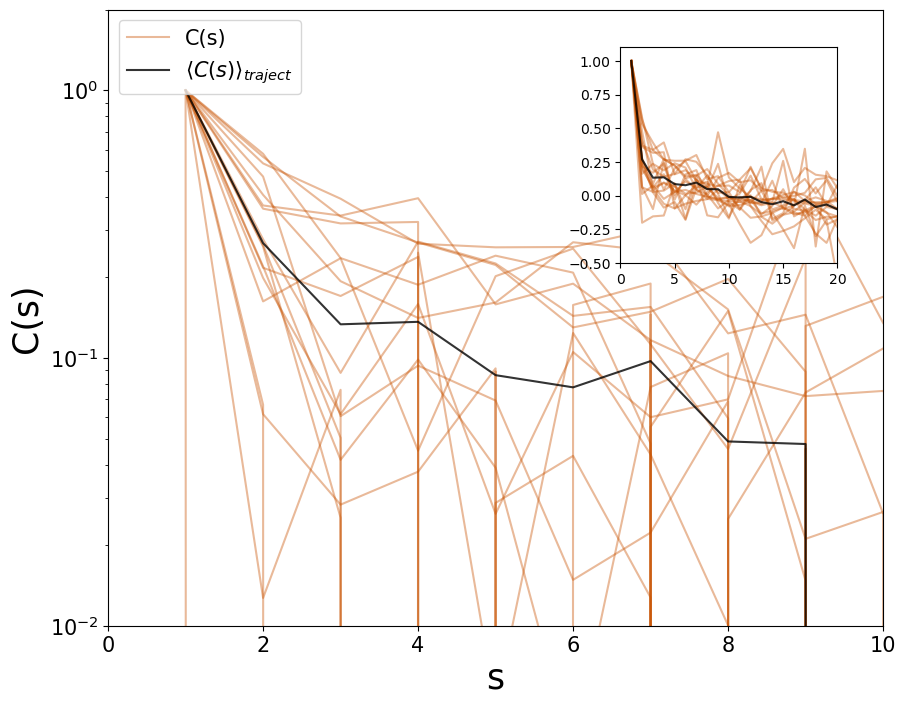

In [172]:
all_files = glob.glob(os.path.join("processed data\\*.csv")) # Make list of paths (csv files for all individual trajectories)

# Create the figure
fig, ax1 = plt.subplots(figsize=(10,8))   
axins1 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,0.60,.35,.35), bbox_transform=ax1.transAxes)
ax1.set_ylabel('C(s)',fontsize=25)
ax1.set_xlabel('s',fontsize=25)
ax1.tick_params(labelsize=15)
ax1.set_yscale('log',base=10) 
#ax1.set_xscale('log',base=10) 

autocorr_all=[] # List of lists:  C(s)_all = [ [C(s)_traject_1], [C(s)_traject_2], ...,[] ]
number_of_trajectories=0
label_added = False  # To avoid plot multiple legend values
for file in all_files:   # Loop over all .csv files
    df = pd.read_csv(file)
    number_of_trajectories = number_of_trajectories + 1
    
    print(file)
    print('M = {} velocities'.format(len(n_points)))
    n_points, autocorr = autocorrelation_velocities(df)
    print('')
    
    autocorr_all.append(autocorr)  # List of lists. Each list is the individual average MSD(s) (unique trajectory)
    
    if not label_added:
        ax1.plot(n_points, autocorr, '-', color='#C85200',alpha=0.4,label='C(s)')  # Plot each trajectory (MSD) individually
        axins1.plot(n_points, autocorr,'-',color='#C85200',alpha=0.4)
        label_added = True
    else:
        ax1.plot(n_points, autocorr, '-', color='#C85200',alpha=0.4)  # Plot each trajectory (MSD) individually
        axins1.plot(n_points, autocorr,'-',color='#C85200',alpha=0.4)

    
    
# AVERAGE OVER ALL TRAJECTORIES (AT EACH "S")
length_largest_autocorr_list = len(max(autocorr_all))  # lenght of the largest C(s) list (of all the trajectories)

autocorr_all_traj_avg=[]
ss=0
n_points_largest_traject=[]
for s in range(length_largest_autocorr_list):   # Loop from s=0 to the lenght of the largest trajectory (C(s) list)
    autocorr_all_s=[]
    for i in autocorr_all:   # Loop over every MSD list 
        if len(i)>s:  # Necessary condition since each C(s) list has different length. We can only store a value of the MSD of a
                      # given list if its length is larger than "s". Of course, the last iteration p = length_largest_msd_list 
                      # will only store 1 value corresponding to the MSD(s) value of the largest list (largest trajectory).
                    
            autocorr_all_s.append(i[s])
    autocorr_all_traj_avg.append(np.mean(autocorr_all_s))  # We store the average over all trajectories for a given "s".
    ss=ss+1
    n_points_largest_traject.append(ss)

# Plot averaged MSD over all trajectories (at each s)
ax1.plot(n_points_largest_traject, autocorr_all_traj_avg, '-', color='black',label=r'$\langle C(s) \rangle_{traject}$',alpha=0.8)    
axins1.plot(n_points_largest_traject, autocorr_all_traj_avg, '-', color='black',alpha=0.8)

ax1.set_xlim(0,10)
ax1.set_ylim(0.01,2)
axins1.set_ylim(-0.5,1.1)
axins1.set_xlim(0,20)

ax1.legend(fontsize=15,loc='upper left')
plt.show()
    

## 2.2. Double-exponential fit <C(s)>

We fit a double exponential distribution to the aggregated auto-correlation C(s).

$$ C(s) = A·e^{-s/a} + B·e^{-s/b} $$

The FIT exponents are:
a = 0.45 ± 0.11
a = 4.77 ± 1.55


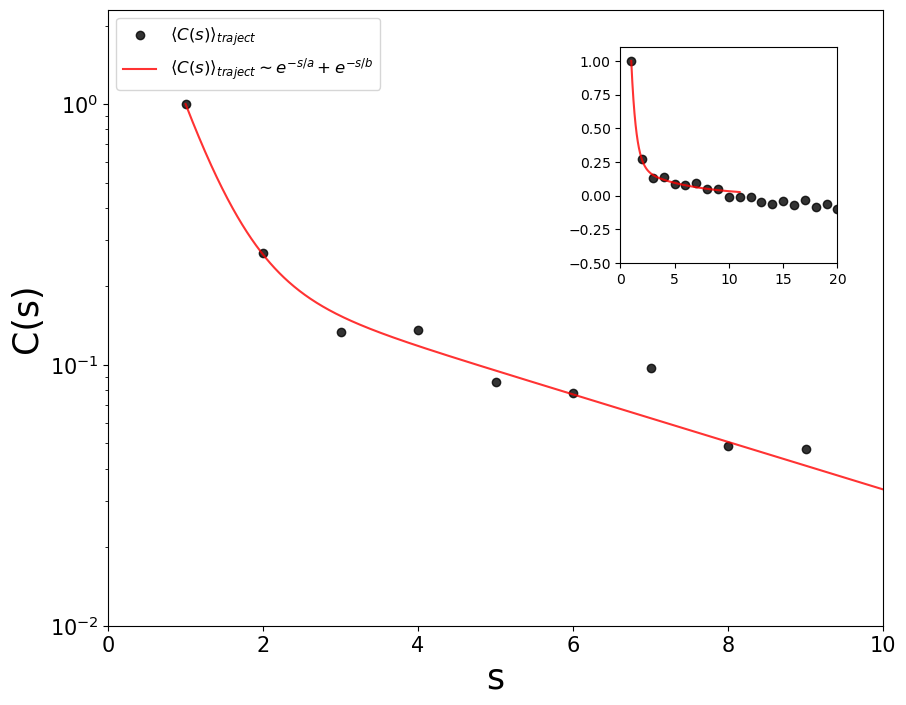

In [186]:
fig, ax1 = plt.subplots(figsize=(10,8))   
axins1 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,0.60,.35,.35), bbox_transform=ax1.transAxes)
ax1.set_ylabel('C(s)',fontsize=25)
ax1.set_xlabel('s',fontsize=25)
ax1.tick_params(labelsize=15)
ax1.set_yscale('log',base=10) 

ax1.plot(n_points_largest_traject, autocorr_all_traj_avg, 'o', color='black',label=r'$\langle C(s) \rangle_{traject}$',alpha=0.8)    
axins1.plot(n_points_largest_traject, autocorr_all_traj_avg, 'o', color='black',alpha=0.8)

ax1.set_xlim(0,10)
ax1.set_ylim(0.01,2.3)
axins1.set_ylim(-0.5,1.1)
axins1.set_xlim(0,20)

ax1.legend(fontsize=15,loc='upper left')


    
# DOUBLE-EXPONENTIAL FIT 

# Double-exponential distribution
def doubleexp(x,A,a,B,b): 
    return A*np.exp(-x/a) + B*np.exp(-x/b)
    
# CURVE-FIT. LEAST-SQUARES
popt, pcov = curve_fit(doubleexp, n_points_largest_traject[:10], autocorr_all_traj_avg[:10], p0=(1,1,1,1))
times = np.arange(n_points_largest_traject[0], n_points_largest_traject[10], 0.01)
model = doubleexp(times, *popt)
perr = np.sqrt(np.diag(pcov))  #calcul error del parametre

ax1.plot(times, model, '-', color='red',label=r'$\langle C(s) \rangle_{traject} \sim e^{-s/a}+e^{-s/b}$',alpha=0.8)

axins1.plot(times, model, '-', color='red',alpha=0.8)

ax1.legend(fontsize=12,loc='upper left')

print('The FIT exponents are:')
print('a = {:.2f} \u00B1 {:.2f}'.format(popt[1],perr[1]))
print('a = {:.2f} \u00B1 {:.2f}'.format(popt[3],perr[3]))




plt.show()

# 3. Probability density function velocities. Log-Normal distribution fit

We fit the pdf of instantaneous velocities with a Log-Normal distribution of the form:

$$ \Large p(v)=\frac{1}{v\sqrt{2\pi \sigma^{2}}} e^{-\frac{log(v/v_{o})^{2}}{2\sigma^{2}}} $$

The FIT parametres are:
σ = 0.34 ± 0.01
v0 = 1.12 ± 0.01


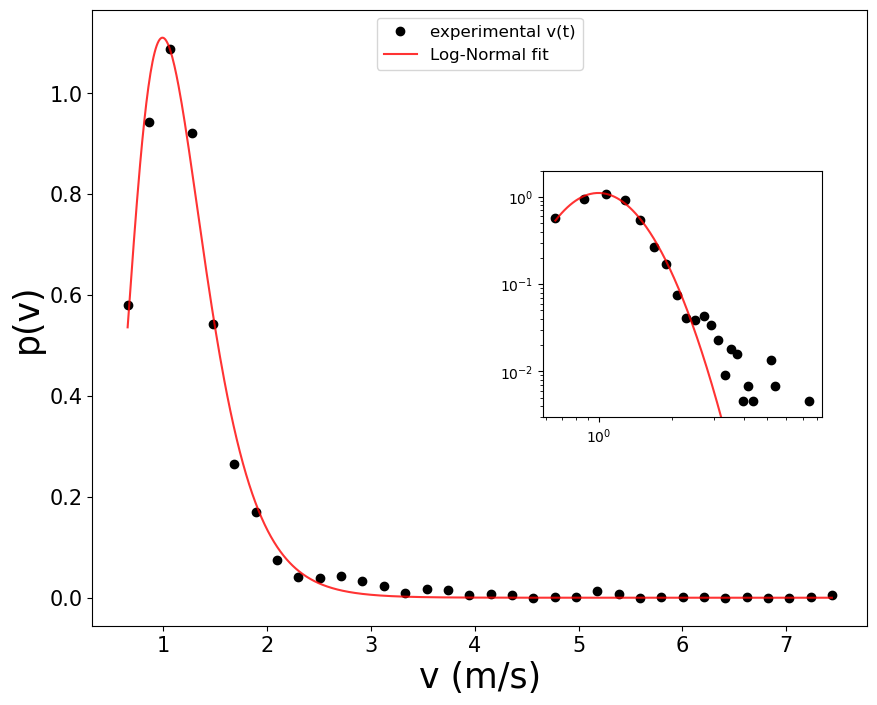

In [194]:
def histogram(x,width_bins):
    """ Function that creates a normalized histogram. It returns the counts (normalized frequences) and the positions of the 
        bins center.
        
        Inputs: 
            - variable x (list or array)
            - width of the bins
            
        Outputs:
            - Normalized counts (the normalization is such that the area below the curve is 1)
            - Bin centres (the position of the center of each bin)
    """
    
    numpy_matrix = np.array(x)
    bins=int((max(x)-min(x))/width_bins)
    counts,bin_edges = np.histogram(numpy_matrix,bins=bins,density=True)   # frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center
    
    return bin_centres, counts

# First, we iterate over all the .csv files and extract the velocity vector of each trajectory
# We only consider those velocities labelled as "moving".
# Finally, we disregard those velocities which are higher than 8 m/s (probably outliers due to GPS error)

all_files = glob.glob(os.path.join("processed data\\*.csv")) # Make list of paths (csv files for all individuals)
velocities=[] 
for file in all_files:   # Loop over all csv files in the folder/directory   
    df = pd.read_csv(file)  # Read the csv file of each user
    df2=df.copy() 
    
    v2=df2.loc[df2['stops'] == 'moving', 'v'].tolist()    # Take only the data-set points labelled as flight
    
    v=[]
    for i in range(len(v2)):    # We disregard velocities greater than 8m/s (outliers)
        if v2[i]<8.0:
            v.append(v2[i])
    
    velocities.extend(v)

# Create the histogram using bins of 0.2 m/s width
bin_centres_v, counts_v = histogram(velocities, 0.2)

# Plot the histogram
fig, ax = plt.subplots(figsize=(10,8)) 

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="80%", height="100%", loc=1,bbox_to_anchor=(0.50,1-0.65,.45,.40), bbox_transform=ax.transAxes)

ax.plot(bin_centres_v, counts_v, 'o', color='black',label='experimental v(t)')    #plot pdf
axins.plot(bin_centres_v, counts_v, 'o', color='black', label='experimental v(t)')    #plot pdf

axins.set_ylim(0.003,2)
ax.set_xlabel('v (m/s)',fontsize=25)
ax.set_ylabel('p(v)',fontsize=25)
axins.set_yscale('log',base=10)
axins.set_xscale('log',base=10)
ax.tick_params(labelsize=15)


# LOG-NORMAL FIT

# Log-Normal distribution with parameters v0 and sigma
def lognormal_pdf(x,sigmag,v0):
    'Log-Normal distribution with inputs: sigma (shape) and mu=ln(v0) (mean, scale)'
    return (1./(sigmag*np.sqrt(2*math.pi)*(x)))*np.exp(-(np.power((np.log(x/v0)),2)/(2*np.power(sigmag,2))))

popt, pcov = curve_fit(lognormal_pdf, bin_centres_v, counts_v, p0=(1,1))
times = np.arange(bin_centres_v[0], bin_centres_v[-1], 0.01)
model = lognormal_pdf(times, *popt)
perr = np.sqrt(np.diag(pcov))  #calcul error del parametre

ax.plot(times, model, '-', color='red',label='Log-Normal fit',alpha=0.8)
axins.plot(times, model, '-', color='red',alpha=0.8)

ax.legend(fontsize=12,loc='upper center')

print('The FIT parametres are:')
print('\u03C3 = {:.2f} \u00B1 {:.2f}'.format(popt[0],perr[0]))
print('v0 = {:.2f} \u00B1 {:.2f}'.format(popt[1],perr[1]))


plt.show()